In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

In [2]:
# how many dates do we have? 
workdir = '/data/ocp4/LagunaSalada/'
alooks=4
rlooks=20
#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'
pixx=2090
pixy=1793

pixx2=3000
pixy2=1793

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
print(str(len(dates))+' dates so far!')
nd=len(dates)
#print(type(dates))
#print(dates)

# convert these strings to datetime 


211 dates so far!


In [3]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date with layer containing alooks x rlooks pixels from each SLC
slcCP=np.ndarray([len(dates),alooks,rlooks],'complex')
slcNotCP=np.ndarray([len(dates),alooks,rlooks],'complex')

# pull out the alooks x rlooks box of pixels from pixel in Cerro Prieto geothermal field  
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcCP[i,:,:] = ds.GetRasterBand(1).ReadAsArray(pixx-rlooks/2,pixy-alooks/2,rlooks,alooks)

# do the same for the pixel just outside of CP geotherm field 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcNotCP[i,:,:] = ds.GetRasterBand(1).ReadAsArray(pixx2-rlooks/2,pixy2-alooks/2,rlooks,alooks)
    

In [4]:
# calculate phase change over each igram interval 

# dates is a list of strings, from cell above.

# convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

# calculate dt between slcs 
dt = np.diff(slc_dates)
# these are now timedelta objects

# convert to floats 
dt2 = np.zeros([len(dt),1])

for i in range(0,len(dt)):
    dt2[i] = dt[i].days
# dt2 is now an array of float64

#dt2 = 1/dt2*365.25

#print(dt2)

In [5]:
# initialize empty nd x nd array for storing coherence values for each SLC pair/igram
# phase is difference (conjugate) between  at pt 1 and pt 2
allphase=np.zeros([nd-1,1])
coh=np.zeros([nd-1,1])

# assigning integer values to SLC pairs 
numints = np.cumsum(np.arange(nd))
numints=np.max(numints)
# what does this do?
ids=np.ndarray([numints,2])

# making interferograms, looping thru i, j dates 
for i in np.arange(nd-1):
    j = i+1
    # is is first date, j is comparison date

    
    # Using this method: <a b*> / <abs(a b*)>

    # a b*
    ints=slcCP[i,:,:] * np.conj(slcCP[j,:,:])
    ints2=slcNotCP[i,:,:] * np.conj(slcNotCP[j,:,:])
    # take the mean over all the pixels in this area (complex space) complex coherence
    # <a b*>
    cov=np.mean(ints,axis=(0,1)) # complex number, of which phase is angle 
    # mag of this is the coherence at that point 
    cov2=np.mean(ints2,axis=(0,1))
    # <abs (a b*)>
    intmag=np.mean(np.abs(ints),axis=(0,1))
    intmag2=np.mean(np.abs(ints2),axis=(0,1))
    # coherence magnitude, simplest way of doing it 
    # <a b*> / <abs(a b*)>
    covw = cov/intmag
    covw2 = cov2/intmag2
    # put these into a 2-element array
    toAvg = [covw, covw2]
    # average the two coherence magnitudes from the two points
    coh[i] = np.mean(np.abs(toAvg))

    # now we have covs at pt 1 and 2 
    allphase[i]=np.angle(cov*np.conj(cov2))

    # angle instead of mag
    #allphase[i,j]=np.angle(covw)  
    
    
#print(np.shape(cov))
#print(cov)
#print(covw)
#print(covw2)
#print(coh[0:10])

cumulative = np.cumsum(allphase)
# try a cumulative sum? See them go up? 


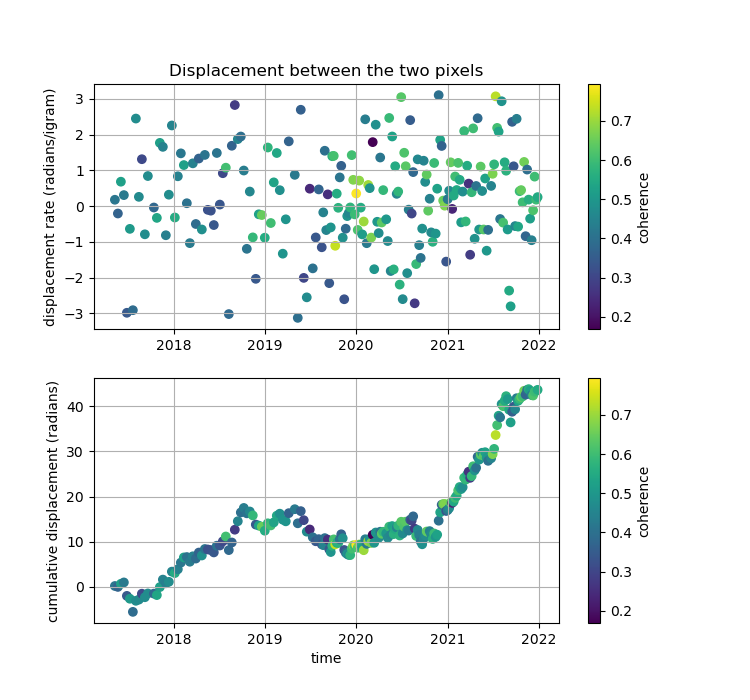

In [6]:
plt.figure(figsize=(7.5, 7))
ax = plt.subplot(2, 1, 1)

plt.scatter(slc_dates[0:-1],allphase, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement rate (radians/igram)')
plt.title('Displacement between the two pixels')

ax = plt.subplot(2, 1, 2)
plt.scatter(slc_dates[0:-1],cumulative, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (radians)')

plt.show()

# last coherence value is zero (because it isn't a real igram?)
#print(coh[-1])

In [7]:
#print(dt2)
print((-3*1.44940476*5.6)/(4*np.pi))

-1.9377114295973463


In [8]:
#CONVERTING RADIANS TO CM 

#print(np.shape(dt2))
#print(len(slc_dates))
#print(len(allphase))
#print(len(coh))

# what about cm/year instead of radians/time interval of igram

# element by element multiplication, just in case
#allphase2 = np.multiply(allphase,dt2) # so this is radians/year now
dispcm = allphase*5.6/(4*np.pi) # disp/igram

ratecm = dispcm*365.25/dt2

cumulative2 = np.cumsum(dispcm,0)
# try a cumulative sum? See them go up? 

#print(np.shape(cumulative2))
#print(np.shape(disp))

avgrate = np.mean(ratecm)
print(avgrate)


4.868627544077569


In [9]:
print("allphase: "+str(np.shape(allphase)))
print("slc_dates: "+str(np.shape(slc_dates)))
print("dispcm: "+str(np.shape(dispcm)))
print("ratecm: "+str(np.shape(ratecm)))
print("coh: "+str(np.shape(coh)))
print("dt2: "+str(np.shape(dt2)))

allphase: (210, 1)
slc_dates: (211,)
dispcm: (210, 1)
ratecm: (210, 1)
coh: (210, 1)
dt2: (210, 1)


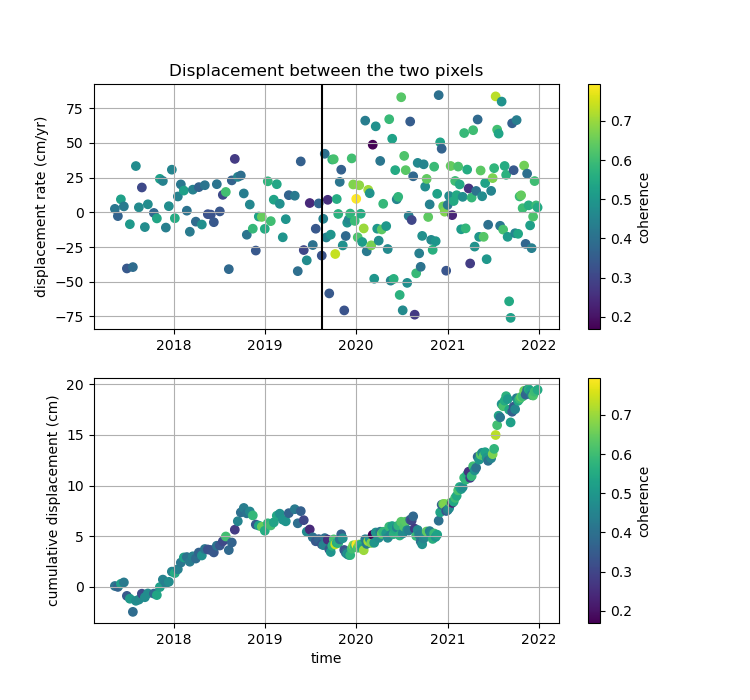

In [10]:
plt.figure(figsize=(7.5, 7))
ax = plt.subplot(2, 1, 1)

plt.scatter(slc_dates[0:-1], ratecm, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement rate (cm/yr)')
plt.title('Displacement between the two pixels')
# 20190816 is when the 6-day pairs started 
plt.axvline(x = datetime(2019, 8, 16, 0, 0), color='k')

ax = plt.subplot(2, 1, 2)
plt.scatter(slc_dates[0:-1], cumulative2, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')

plt.show()


# 12-day pairs are less noisy 
# could put a line where switches over from 12-day to 6-day pairs 


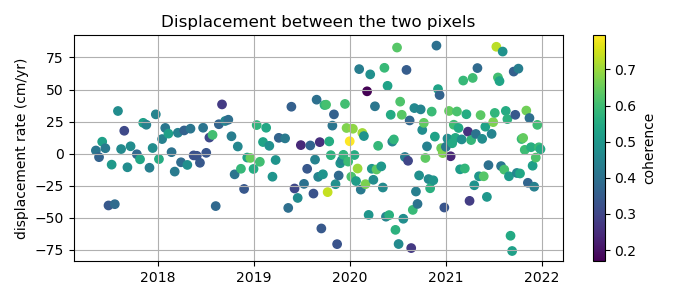

In [11]:
plt.figure(figsize=(7, 3), tight_layout=True)
ax = plt.subplot(1, 1, 1)
plt.scatter(slc_dates[0:-1], ratecm, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement rate (cm/yr)')
plt.title('Displacement between the two pixels')
# 20190816 is when the 6-day pairs started 
#plt.axvline(x = datetime(2019, 8, 16, 0, 0), color='k')
plt.show()

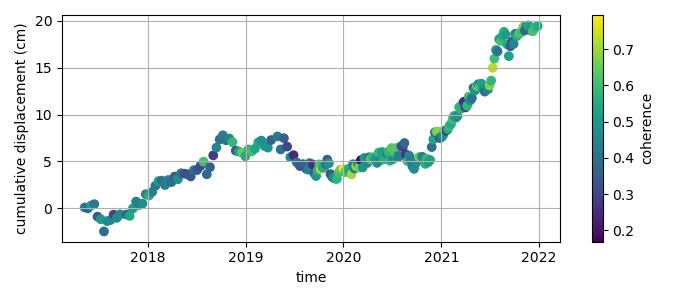

In [12]:
plt.figure(figsize=(7, 3), tight_layout=True)
ax = plt.subplot(1, 1, 1)
plt.scatter(slc_dates[0:-1], cumulative2, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
plt.show()